## RNN by LSTM

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Data preparation

In [2]:
df = pd.read_csv('Air_pollution.csv')

In [3]:
df.shape

(43824, 13)

In [4]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [6]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [30]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir'],
      dtype='object')

### Normalize the Features

In [7]:
# Fill missing values
df['pm2.5'].fillna(df['pm2.5'].mean(), inplace=True)


In [8]:
# Encode categorical data
df['cbwd'] = df['cbwd'].astype('category').cat.codes


In [9]:
# Select features and target
features = df[['year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']]
target = df['pm2.5']


In [10]:
# Normalize the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Normalize the target
target_scaler = MinMaxScaler()
scaled_target = target.values.reshape(-1, 1)
scaled_target = target_scaler.fit_transform(scaled_target)



### Prepare Data for LSTM

In [11]:
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 24  # Example: Use past 24 hours to predict next hour
X, y = create_sequences(scaled_features, scaled_target, time_steps)


In [12]:
# Split the data into training and testing sets (keeping temporal order)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [31]:
print(f'X_train: {X_train.shape} \t, X_test: {X_test.shape}')

X_train: (35040, 24, 11) 	, X_test: (8760, 24, 11)


### Build and Train the LSTM Model

In [13]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')



In [14]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [15]:
# Train the model
Hist = model.fit(X_train, y_train, epochs=30, batch_size=76, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/30
369/369 [==============================] - 28s 53ms/step - loss: 0.0065 - val_loss: 0.0048
Epoch 2/30
369/369 [==============================] - 17s 47ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 3/30
369/369 [==============================] - 17s 46ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 4/30
369/369 [==============================] - 17s 46ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 5/30
369/369 [==============================] - 17s 47ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 6/30
369/369 [==============================] - 18s 48ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 7/30
369/369 [==============================] - 17s 46ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 8/30
369/369 [==============================] - 19s 51ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 9/30
369/369 [==============================] - 18s 49ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/30
369/369 [==============================] - 19s 51ms/step - loss: 0.003

### Evaluate and Visualize Results

In [16]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


274/274 [==============================] - 4s 14ms/step - loss: 0.0125
Test Loss: 0.01245546992868185


In [17]:
# Make predictions
y_pred = model.predict(X_test)


274/274 [==============================] - 6s 16ms/step


In [18]:
# After prediction
# Inverse transform predictions and actual values
y_test = target_scaler.inverse_transform(y_test)
y_pred = target_scaler.inverse_transform(y_pred)


In [24]:
# Print first 5 actual and predicted values after inverse transformation
print("First 5 Actual Values (after inverse transform):\n", y_test[:5])
print("First 5 Predicted Values (after inverse transform):\n", y_pred[:5])


First 5 Actual Values (after inverse transform):
 [[24.]
 [53.]
 [65.]
 [70.]
 [79.]]
First 5 Predicted Values (after inverse transform):
 [[16.99103 ]
 [17.42737 ]
 [14.598561]
 [13.146194]
 [13.037121]]


In [20]:
# Calculate and print error
mse = mean_squared_error(y_test, y_pred)
print(f'Test Mean Squared Error: {mse}')


Test Mean Squared Error: 12306.449594492551


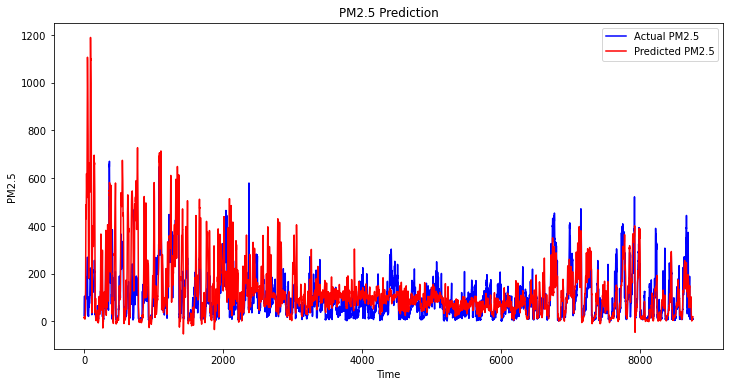

In [26]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(y_test, color='blue', label='Actual PM2.5')
plt.plot(y_pred, color='red', label='Predicted PM2.5')
plt.title('PM2.5 Prediction')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


### Plot the Loss


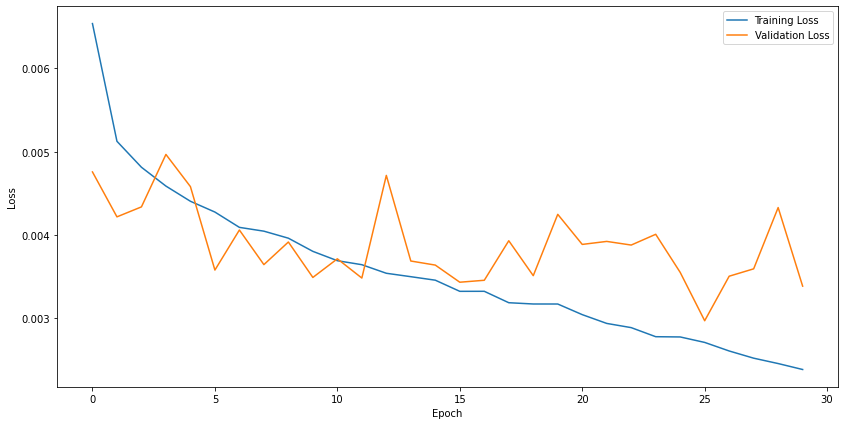

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(Hist.history['loss'], label='Training Loss')
plt.plot(Hist.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
